**Configuration Summary:**
- Model: roberta-base + LoRA
- LoRA Rank: 8, Alpha: 16
- Dropout: 0.1
- Target Modules: query, value
- Epochs: 5
- Learning Rate: 2.5e-5
- Max Length: 128
- Warmup Ratio: 0.1
- Scheduler: linear
- Batch Size: 64
- Seed: 42
- No label smoothing

In [ ]:
!pip install -q transformers datasets peft accelerate evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 939.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
#Load and tokenize dataset
from datasets import load_dataset, Dataset
import pandas as pd
from transformers import RobertaTokenizer

dataset = load_dataset("ag_news")
split_data = dataset["train"].train_test_split(test_size=0.1, seed=42)
train_data = split_data["train"]
val_data = split_data["test"]

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_data.map(tokenize, batched=True).rename_column("label", "labels").remove_columns(["text"]).with_format("torch")
val_dataset = val_data.map(tokenize, batched=True).rename_column("label", "labels").remove_columns(["text"]).with_format("torch")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/108000 [00:00<?, ? examples/s]

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

In [ ]:
#Setup LoRA model
from transformers import RobertaForSequenceClassification
from peft import get_peft_model, LoraConfig, TaskType

model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=4)
for p in model.base_model.parameters():
    p.requires_grad = False

config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    target_modules=["query", "value"],
    task_type=TaskType.SEQ_CLS
)

model = get_peft_model(model, config)
print("Trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))
print("Total parameters:", sum(p.numel() for p in model.parameters()))

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable parameters: 888580
Total parameters: 125537288


In [ ]:
#Training

from transformers import TrainingArguments, Trainer, DataCollatorWithPadding, set_seed
import evaluate
import numpy as np

set_seed(42)
args = TrainingArguments(
    output_dir="./final_model",
    learning_rate=2.5e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    fp16=True,
    weight_decay=0.01,
    warmup_ratio=0.1,
    lr_scheduler_type="linear",
    logging_dir="./logs",
    report_to="none",
    seed=42,
    #evaluation_strategy="steps",
   # eval_steps=250
)

accuracy = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=preds, references=labels)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics
)

trainer.train()

<ipython-input-13-1519dc0e2422>:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
500,1.256500
1000,0.321800
1500,0.281200
2000,0.266000
2500,0.264000
3000,0.254800
3500,0.248000
4000,0.244800
4500,0.241800
5000,0.241300


Step,Training Loss
500,1.256500
1000,0.321800
1500,0.281200
2000,0.266000
2500,0.264000
3000,0.254800
3500,0.248000
4000,0.244800
4500,0.241800
5000,0.241300


TrainOutput(global_step=8440, training_loss=0.30786977740825633, metrics={'train_runtime': 2291.5179, 'train_samples_per_second': 235.652, 'train_steps_per_second': 3.683, 'total_flos': 3.588914221056e+16, 'train_loss': 0.30786977740825633, 'epoch': 5.0})

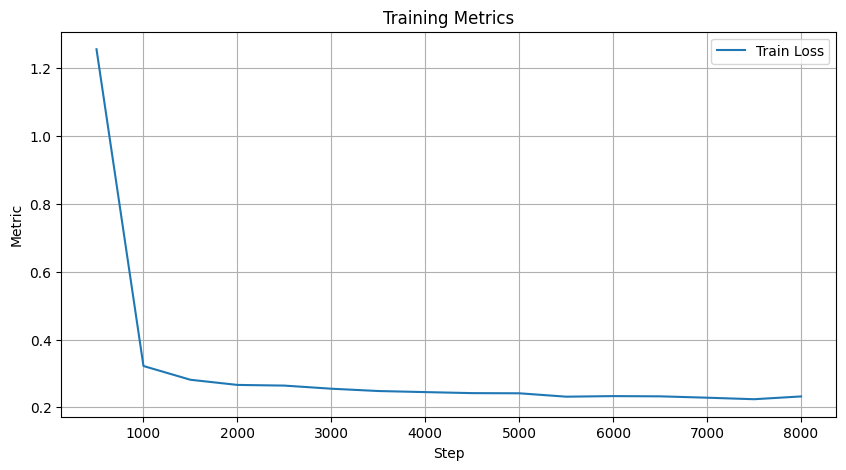

In [ ]:
#Plot loss and accuracy
import matplotlib.pyplot as plt

log = trainer.state.log_history
losses, accs, steps = [], [], []

for entry in log:
    if "loss" in entry and "step" in entry:
        steps.append(entry["step"])
        losses.append(entry["loss"])
    if "eval_accuracy" in entry:
        accs.append(entry["eval_accuracy"])

plt.figure(figsize=(10, 5))
plt.plot(steps, losses, label="Train Loss")
eval_steps = [entry["step"] for entry in log if "eval_accuracy" in entry]
if eval_steps:
    plt.plot(eval_steps, accs, label="Eval Accuracy")
plt.xlabel("Step")
plt.ylabel("Metric")
plt.title("Training Metrics")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Metrics on validation set
results = trainer.evaluate(val_dataset)
print("\n Validation Metrics:")
for k, v in results.items():
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")


 Validation Metrics:
eval_loss: 0.2179
eval_accuracy: 0.9236
eval_runtime: 21.3217
eval_samples_per_second: 562.8070
eval_steps_per_second: 17.5880
epoch: 5.0000


In [ ]:
#Generate submission file
from google.colab import files
uploaded = files.upload()

pkl_file = [k for k in uploaded if k.endswith(".pkl")][0]
df_unlabelled = pd.read_pickle(pkl_file)
if hasattr(df_unlabelled, "to_pandas"):
    df_unlabelled = df_unlabelled.to_pandas()

submission_dataset = Dataset.from_pandas(df_unlabelled[["text"]])
submission_dataset = submission_dataset.map(lambda x: tokenizer(x["text"], padding="max_length", truncation=True, max_length=128), batched=True)
submission_dataset = submission_dataset.remove_columns(["text"]).with_format("torch")

preds = trainer.predict(submission_dataset)
labels = np.argmax(preds.predictions, axis=-1)

submission = pd.DataFrame({
    "ID": df_unlabelled["id"] if "id" in df_unlabelled.columns else np.arange(len(labels)),
    "Label": labels
})
submission.to_csv("submission.csv", index=False, encoding="utf-8")
files.download("submission.csv")

Saving test_unlabelled.pkl to test_unlabelled.pkl


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>